In [10]:
!pip uninstall torch -y
!pip install torch==2.2.2

Found existing installation: torch 2.3.0
Uninstalling torch-2.3.0:
  Successfully uninstalled torch-2.3.0
  Using cached torch-2.2.2-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl.metadata (1.8 kB)
  Using cached triton-2.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
Using cached torch-2.2.2-cp311-cp311-manylinux1_x86_64.whl (755.6 MB)
Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
Using cached triton-2.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (167.9 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully uninstalled nvidia-nccl-cu12-2.20.5
ERROR: pip's dependency resolve

In [5]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [6]:
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir, 
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|███████████████████████████████████████████| 6/6 [00:08<00:00,  1.38s/it]


Source image size: (2048, 1354)
Target image size: (512, 512)


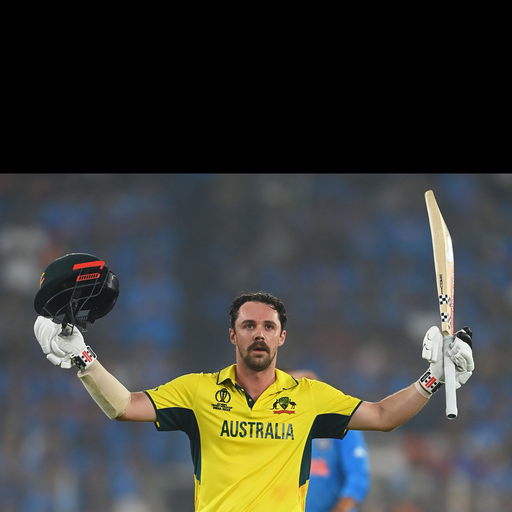

In [7]:
target_width, target_height = 512,512
source_image = Image.open('me.jpg')

width, height = source_image.size
print(f"Source image size: {source_image.size}")

source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)

source_image = source_image.resize((target_width, target_height), Image.LANCZOS )
print(f"Target image size: {source_image.size}")

segmentation_image = asarray(source_image)

display(source_image)

In [9]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

### Pay attention to the pred_iou_thresh, the lower the more masks it will generate. Make it higher to generate masks only of 
### good quality and less number of them
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.999, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [10]:
masks = mask_generator.generate(segmentation_image)
print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

Number of masks generated: 8
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [13]:
def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')

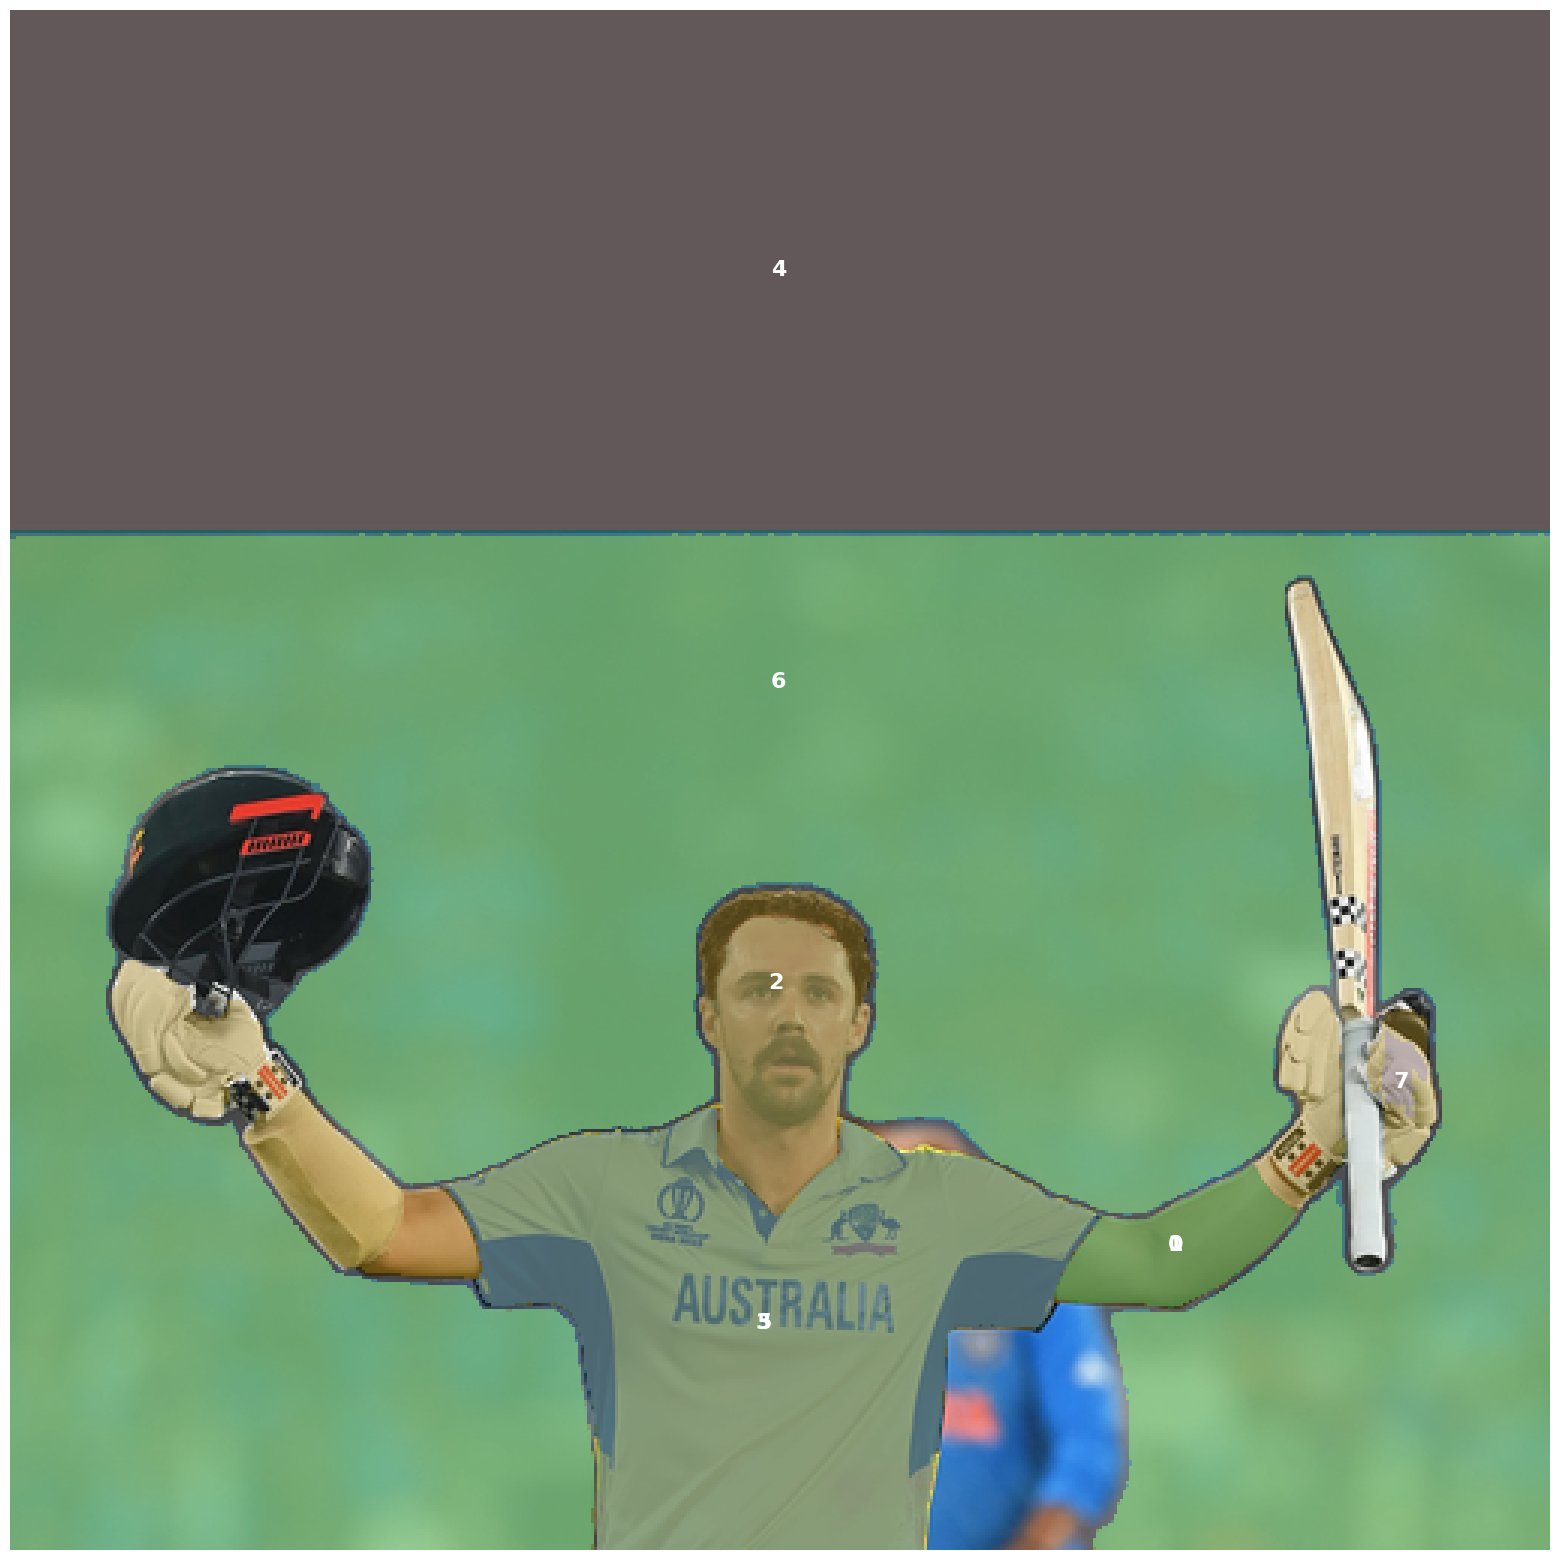

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)  # use masks[:-x] to only display the first masks of the list
plt.axis('off')
plt.show()

In [15]:
for ind, values in enumerate(masks):
   print(f"{ind}: Area: {values['area']} | IoU: {values['predicted_iou']}")

0: Area: 5867 | IoU: 1.0152859687805176
1: Area: 2109 | IoU: 1.0005700588226318
2: Area: 123024 | IoU: 1.021633267402649
3: Area: 19532 | IoU: 1.0193923711776733
4: Area: 88576 | IoU: 1.01429283618927
5: Area: 19739 | IoU: 1.032060146331787
6: Area: 213306 | IoU: 1.0226891040802002
7: Area: 32521 | IoU: 1.014112114906311


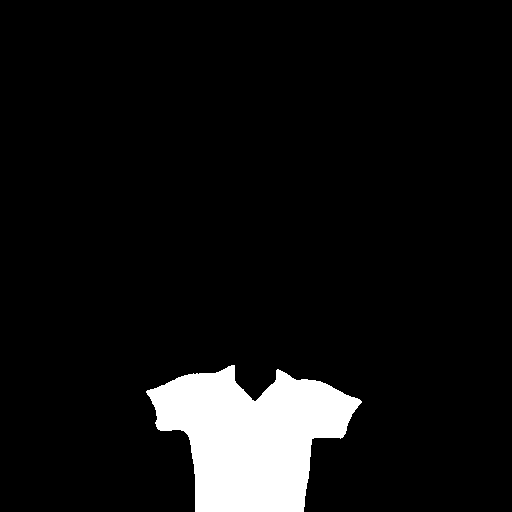

In [16]:
mask_index = 3
segmentation_mask=masks[mask_index]['segmentation']
stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)

In [25]:
num_images_per_prompt = 4
inpainting_prompts = ["india official jersey", "england official jersey", "pakistan official jersey", "sri lankan official jersey"]

generator = torch.Generator(device="cuda").manual_seed(77) # 155, 77, 

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

100%|█████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.12it/s]


In [21]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, 'Original')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()

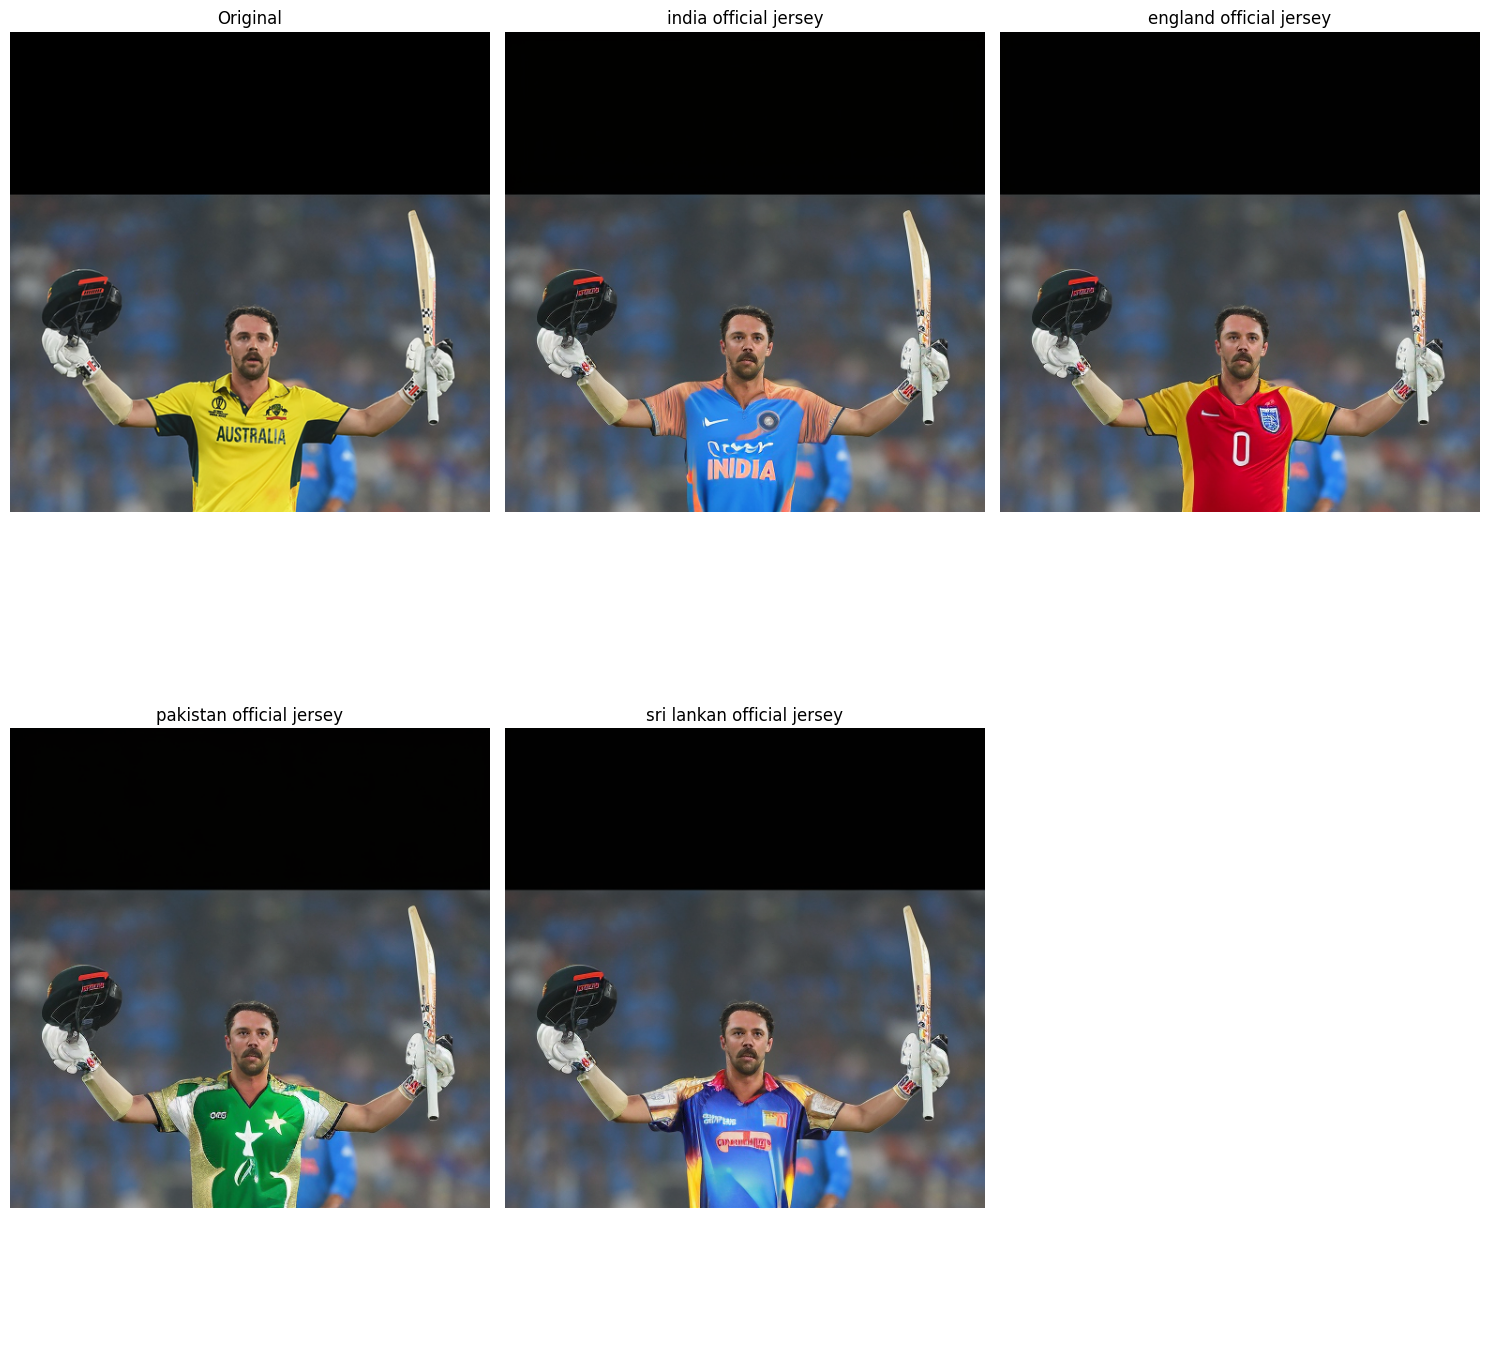

In [26]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)